In [10]:
## mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from keras import backend as K
import tensorflow as tf
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu

from tensorflow.keras import backend as K

In [3]:
## Loss functions

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [4]:
## Display fucntion for visualization

def display(display_list):
 plt.figure(figsize=(10, 10))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

**Part 1**

In [ ]:
## Dataset

train_dir = "/content/drive/MyDrive/Dataset/CV_A2_dataset/train/images_prepped_train"
test_dir = "/content/drive/MyDrive/Dataset/CV_A2_dataset/test/images_prepped_test"

train_images, train_masks = [],[]
for item in os.listdir(train_dir):
    im_path = os.path.join(train_dir, item)
    image = io.imread(im_path)/255.0
    image = cv2.resize(image, (320,320), cv2.INTER_NEAREST)

    mask_path = os.path.join(train_dir.replace('images','annotations'), item)
    mask = io.imread(mask_path)
    mask = np.expand_dims(mask, axis=2)
    mask = cv2.resize(mask, (320,320), cv2.INTER_NEAREST)
    
    train_images.append(image)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)
train_masks = tf.keras.utils.to_categorical(train_masks, num_classes=12)
train_masks = train_masks.astype(np.uint8)

test_images, test_masks = [],[]
for item in os.listdir(test_dir):
    im_path = os.path.join(test_dir, item)
    image = io.imread(im_path)/255.0
    image = cv2.resize(image, (320,320), cv2.INTER_NEAREST)

    mask_path = os.path.join(test_dir.replace('images','annotations'), item)
    mask = io.imread(mask_path)
    mask = np.expand_dims(mask, axis=2)
    mask = cv2.resize(mask, (320,320), cv2.INTER_NEAREST)
    
    test_images.append(image)
    test_masks.append(mask)


test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = tf.keras.utils.to_categorical(test_masks, num_classes=12)
test_masks = test_masks.astype(np.uint8)

print("Training set")
print("Images: ",train_images.shape, " Masks: ",train_masks.shape, "\n")
print("Test set")
print("Images: ",test_images.shape, " Masks: ",test_masks.shape)


Training set
Images:  (367, 320, 320, 3)  Masks:  (367, 320, 320, 12) 

Test set
Images:  (101, 320, 320, 3)  Masks:  (101, 320, 320, 12)


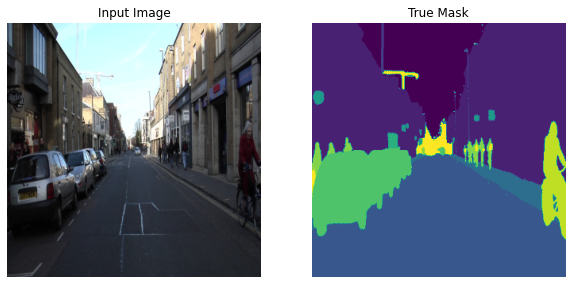

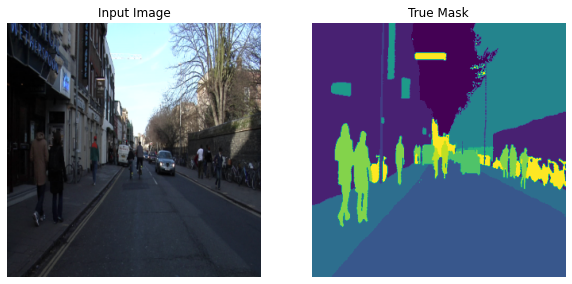

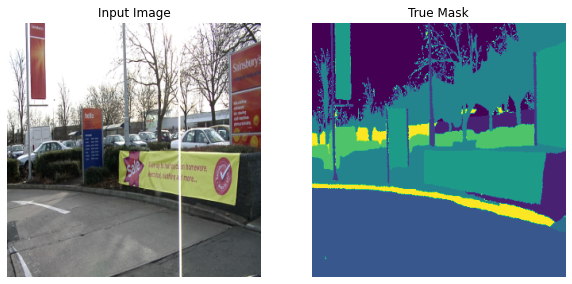

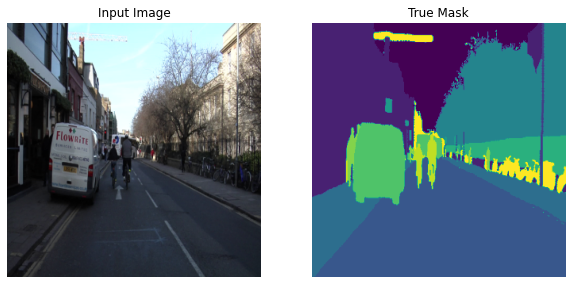

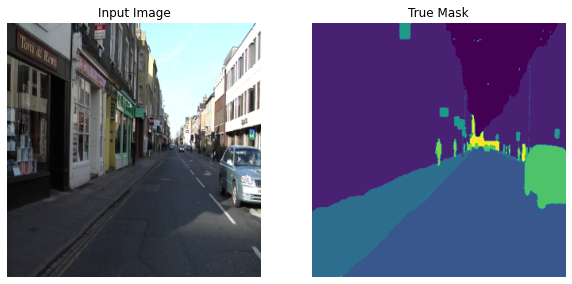

In [ ]:
# Visualization of random 5 input images and corresponding masks
num = [random.randint(0, len(train_images)) for i in range(0,5)]
for i in num:
  display([train_images[i], np.expand_dims(np.argmax(train_masks[i], axis = 2), axis = 2)])

In [ ]:
## train_validation split (70:30)

x_train, x_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.3)
print("Training set:")
print(x_train.shape)
print(y_train.shape)
print("\nValidation set:")
print(x_val.shape)
print(y_val.shape)

Training set:
(256, 320, 320, 3)
(256, 320, 320, 12)

Validation set:
(111, 320, 320, 3)
(111, 320, 320, 12)


In [ ]:
! pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.4 MB/s 


In [ ]:
import segmentation_models as sm
from tensorflow import keras

keras.backend.set_image_data_format('channels_last')

BACKBONE = 'resnet34'


# define model
model = sm.Unet(BACKBONE, input_shape=(None, None, 3), classes=12, activation='softmax', encoder_weights=None,  decoder_use_batchnorm=False)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",dice_coef])

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
results = model.fit(x_train, y_train, batch_size=16,
                         verbose=1, epochs=15, callbacks = callbacks,
                         validation_data=(x_val, y_val))

Epoch 1/15
16/16 [==============================] - 13s 520ms/step - loss: 2.3150 - accuracy: 0.2061 - dice_coef: 0.1632 - val_loss: 494053.4062 - val_accuracy: 0.3166 - val_dice_coef: 0.3165 - lr: 0.0010
Epoch 2/15
16/16 [==============================] - 7s 452ms/step - loss: 1.3904 - accuracy: 0.4980 - dice_coef: 0.4333 - val_loss: 3770.3252 - val_accuracy: 0.2056 - val_dice_coef: 0.2057 - lr: 0.0010
Epoch 3/15
16/16 [==============================] - 7s 455ms/step - loss: 1.1628 - accuracy: 0.6345 - dice_coef: 0.5070 - val_loss: 1852.4725 - val_accuracy: 0.3713 - val_dice_coef: 0.3711 - lr: 0.0010
Epoch 4/15
16/16 [==============================] - 7s 458ms/step - loss: 1.0087 - accuracy: 0.6747 - dice_coef: 0.5625 - val_loss: 221.7776 - val_accuracy: 0.3402 - val_dice_coef: 0.3401 - lr: 0.0010
Epoch 5/15
16/16 [==============================] - 7s 460ms/step - loss: 0.9274 - accuracy: 0.6930 - dice_coef: 0.6003 - val_loss: 37.4279 - val_accuracy: 0.3917 - val_dice_coef: 0.3900 - l

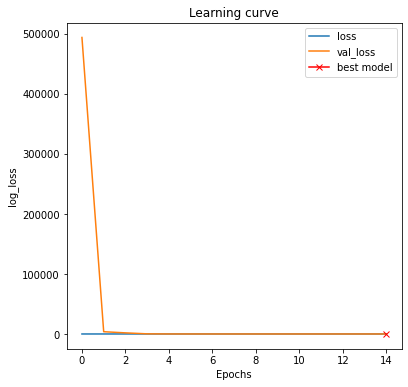

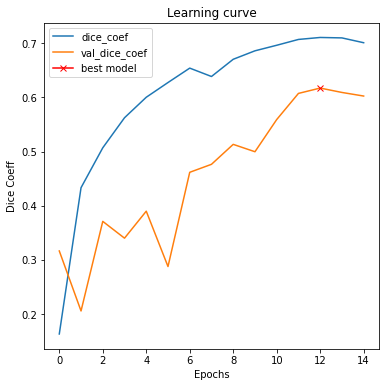

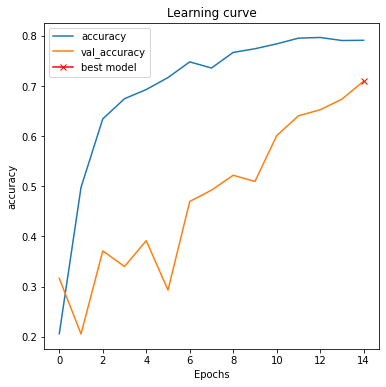

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()


In [ ]:
## Model prediction

pred = model.predict(test_images)

4/4 [==============================] - 1s 236ms/step


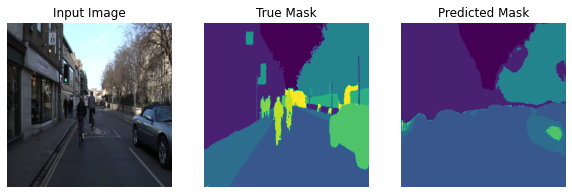

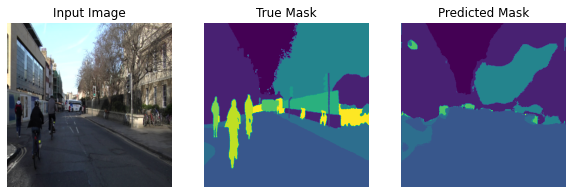

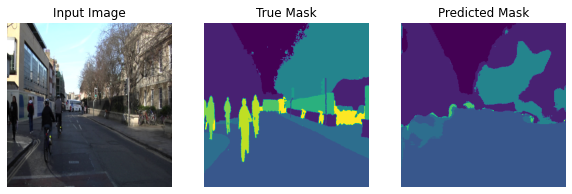

In [ ]:
# Visualization of predicted masks with groud truth
num = [random.randint(0, len(test_images)) for i in range(0,3)]
for i in num:
  display([test_images[i], np.expand_dims(np.argmax(test_masks[i], axis = 2), axis = 2), np.expand_dims(np.argmax(pred[i], axis = 2), axis = 2)])

**Part 2a -** Unet with inceptionv3 as backbone

In [ ]:
import segmentation_models as sm
from tensorflow import keras

keras.backend.set_image_data_format('channels_last')

BACKBONE = 'inceptionv3'


# define model
model = sm.Unet(BACKBONE, input_shape=(None, None, 3), classes=12, activation='softmax', encoder_weights='imagenet',  decoder_use_batchnorm=False)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",dice_coef])

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
results = model.fit(x_train, y_train, batch_size=16,
                         verbose=1, epochs=15, callbacks = callbacks,
                         validation_data=(x_val, y_val))

Epoch 1/15
16/16 [==============================] - 19s 700ms/step - loss: 1.9507 - accuracy: 0.3572 - dice_coef: 0.2902 - val_loss: 711.4952 - val_accuracy: 0.3198 - val_dice_coef: 0.3194 - lr: 0.0010
Epoch 2/15
16/16 [==============================] - 9s 594ms/step - loss: 1.1871 - accuracy: 0.6539 - dice_coef: 0.5296 - val_loss: 55.7045 - val_accuracy: 0.3230 - val_dice_coef: 0.3230 - lr: 0.0010
Epoch 3/15
16/16 [==============================] - 10s 600ms/step - loss: 0.9987 - accuracy: 0.6819 - dice_coef: 0.5943 - val_loss: 12.1057 - val_accuracy: 0.3505 - val_dice_coef: 0.3401 - lr: 0.0010
Epoch 4/15
16/16 [==============================] - 10s 604ms/step - loss: 0.8460 - accuracy: 0.7242 - dice_coef: 0.6515 - val_loss: 1.5991 - val_accuracy: 0.6413 - val_dice_coef: 0.5739 - lr: 0.0010
Epoch 5/15
16/16 [==============================] - 10s 609ms/step - loss: 0.7276 - accuracy: 0.7862 - dice_coef: 0.6988 - val_loss: 1.0060 - val_accuracy: 0.7457 - val_dice_coef: 0.6559 - lr: 0.00

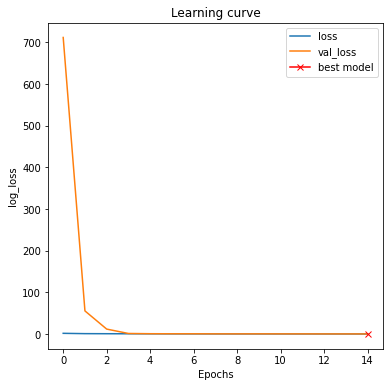

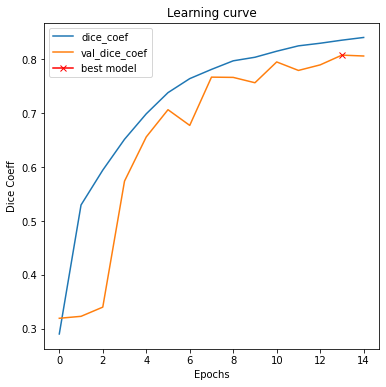

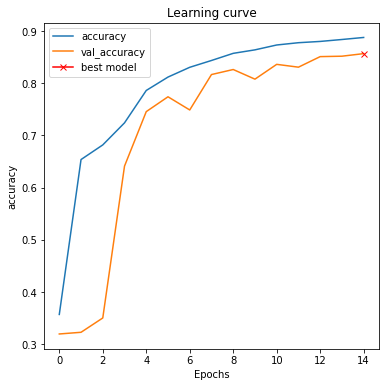

In [ ]:
## Training graphs
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()

In [ ]:
## Model prediction

pred = model.predict(test_images)

4/4 [==============================] - 3s 297ms/step


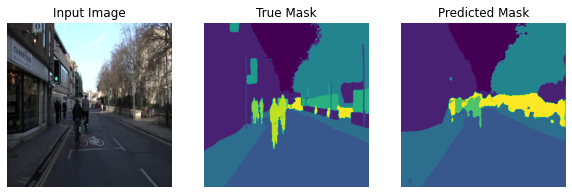

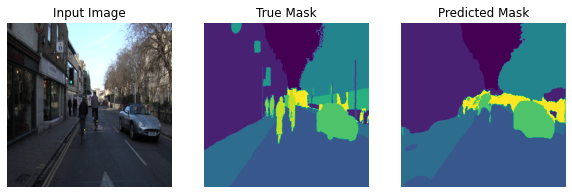

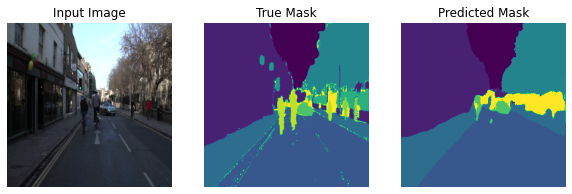

In [ ]:
# Visualization of predicted masks with groud truth
num = [random.randint(0, len(test_images)) for i in range(0,3)]
for i in num:
  display([test_images[i], np.expand_dims(np.argmax(test_masks[i], axis = 2), axis = 2), np.expand_dims(np.argmax(pred[i], axis = 2), axis = 2)])

**Part 2b -** Unet with data augmentation

In [5]:
## Dataset with augmentation

train_dir = "/content/drive/MyDrive/Dataset/CV_A2_dataset/train/images_prepped_train"
test_dir = "/content/drive/MyDrive/Dataset/CV_A2_dataset/test/images_prepped_test"

train_images, train_masks = [],[]
for item in os.listdir(train_dir):
    im_path = os.path.join(train_dir, item)
    image = io.imread(im_path)/255.0
    image = cv2.resize(image, (320,320), cv2.INTER_NEAREST)

    mask_path = os.path.join(train_dir.replace('images','annotations'), item)
    mask = io.imread(mask_path)
    mask = cv2.resize(mask, (320,320), cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    
    train_images.append(image)
    train_masks.append(mask)

    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

    train_images.append(image)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)
train_masks = tf.keras.utils.to_categorical(train_masks, num_classes=12)
train_masks = train_masks.astype(np.uint8)

test_images, test_masks = [],[]
for item in os.listdir(test_dir):
    im_path = os.path.join(test_dir, item)
    image = io.imread(im_path)/255.0
    image = cv2.resize(image, (320,320), cv2.INTER_NEAREST)

    mask_path = os.path.join(test_dir.replace('images','annotations'), item)
    mask = io.imread(mask_path)
    mask = np.expand_dims(mask, axis=2)
    mask = cv2.resize(mask, (320,320), cv2.INTER_NEAREST)
    
    test_images.append(image)
    test_masks.append(mask)


test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = tf.keras.utils.to_categorical(test_masks, num_classes=12)
test_masks = test_masks.astype(np.uint8)

print("Training set")
print("Images: ",train_images.shape, " Masks: ",train_masks.shape, "\n")
print("Test set")
print("Images: ",test_images.shape, " Masks: ",test_masks.shape)



Training set
Images:  (734, 320, 320, 3)  Masks:  (734, 320, 320, 12) 

Test set
Images:  (101, 320, 320, 3)  Masks:  (101, 320, 320, 12)


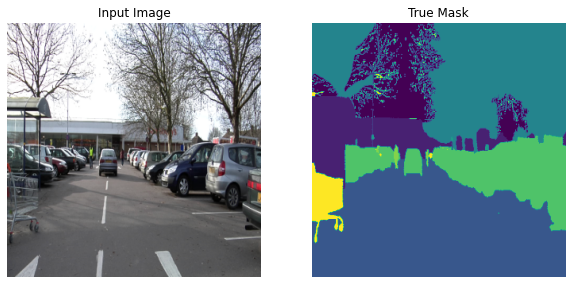

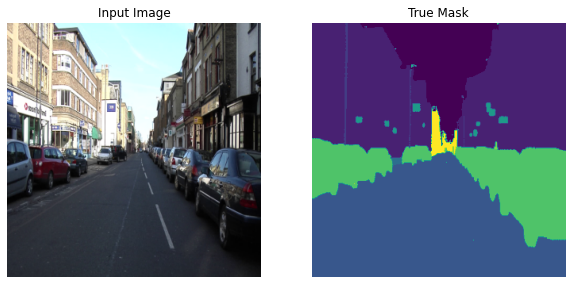

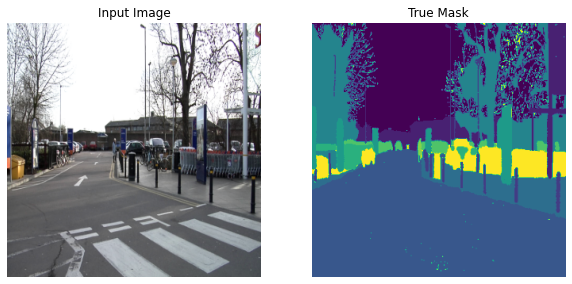

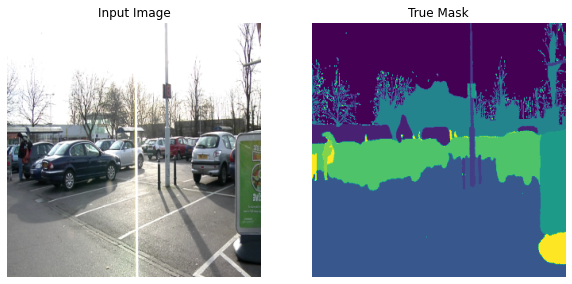

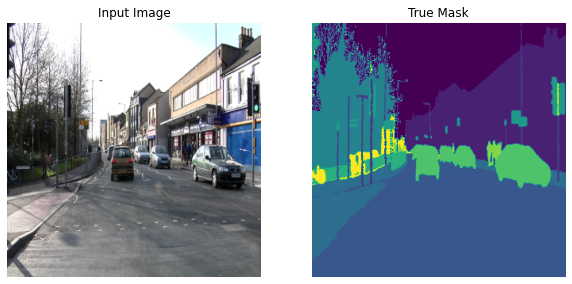

In [ ]:
# Visualization of random 5 augmented images and corresponding masks
num = [random.randint(367, len(train_images)) for i in range(0,5)]
for i in num:
  display([train_images[i], np.expand_dims(np.argmax(train_masks[i], axis = 2), axis = 2)])

In [6]:
## train_validation split (70:30)

x_train, x_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.3)
print("Training set:")
print(x_train.shape)
print(y_train.shape)
print("\nValidation set:")
print(x_val.shape)
print(y_val.shape)

Training set:
(513, 320, 320, 3)
(513, 320, 320, 12)

Validation set:
(221, 320, 320, 3)
(221, 320, 320, 12)


In [7]:
import segmentation_models as sm
from tensorflow import keras

keras.backend.set_image_data_format('channels_last')

BACKBONE = 'inceptionv3'


# define model
model = sm.Unet(BACKBONE, input_shape=(None, None, 3), classes=12, activation='softmax', encoder_weights='imagenet',  decoder_use_batchnorm=False)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",dice_coef])

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
results = model.fit(x_train, y_train, batch_size=16,
                         verbose=1, epochs=5, callbacks = callbacks,
                         validation_data=(x_val, y_val))

Epoch 1/5
33/33 [==============================] - 1527s 46s/step - loss: 2.5792 - accuracy: 0.2751 - dice_coef: 0.2007 - val_loss: 217.1946 - val_accuracy: 0.1794 - val_dice_coef: 0.1812 - lr: 0.0010
Epoch 2/5
33/33 [==============================] - 1523s 46s/step - loss: 1.4029 - accuracy: 0.5092 - dice_coef: 0.4170 - val_loss: 7.8637 - val_accuracy: 0.2351 - val_dice_coef: 0.2524 - lr: 0.0010
Epoch 3/5
33/33 [==============================] - 1535s 47s/step - loss: 1.0326 - accuracy: 0.6751 - dice_coef: 0.5688 - val_loss: 1.0752 - val_accuracy: 0.6715 - val_dice_coef: 0.5452 - lr: 0.0010
Epoch 4/5
33/33 [==============================] - 1535s 47s/step - loss: 0.8543 - accuracy: 0.7285 - dice_coef: 0.6416 - val_loss: 1.1439 - val_accuracy: 0.6780 - val_dice_coef: 0.6233 - lr: 0.0010
Epoch 5/5
33/33 [==============================] - 1538s 47s/step - loss: 0.7187 - accuracy: 0.7799 - dice_coef: 0.7037 - val_loss: 1.1312 - val_accuracy: 0.6521 - val_dice_coef: 0.6097 - lr: 0.0010


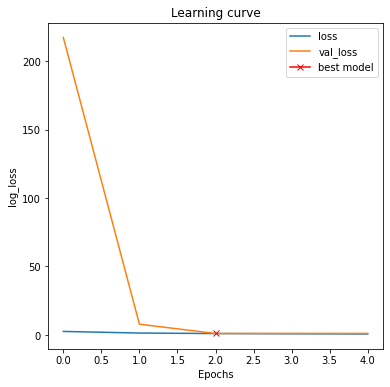

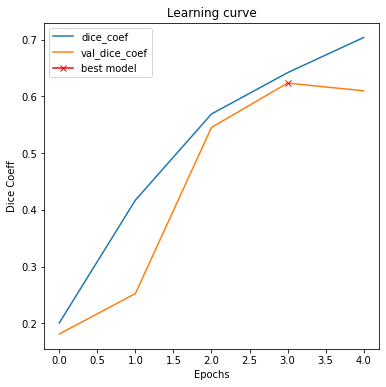

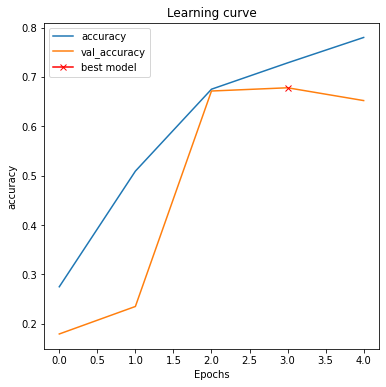

In [8]:
## Training graphs
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()

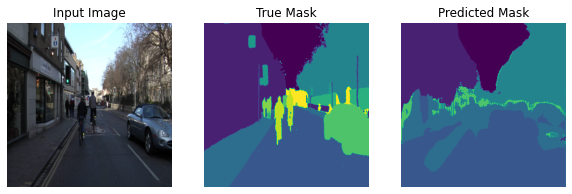

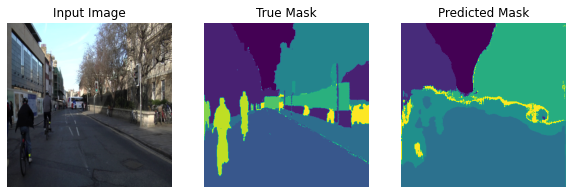

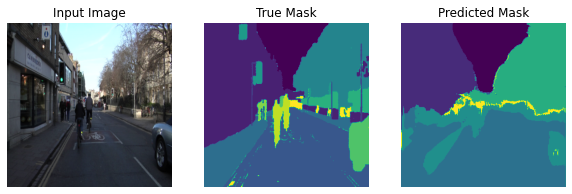

In [17]:
## Model prediction
pred = model.predict(test_images)

# Visualization of predicted masks with groud truth
num = [random.randint(0, len(test_images)) for i in range(0,3)]
for i in num:
  display([test_images[i], np.expand_dims(np.argmax(test_masks[i], axis = 2), axis = 2), np.expand_dims(np.argmax(pred[i], axis = 2), axis = 2)])